# 금융데이터베이스 Group 7 기말프로젝트

* 20249032	곽기은	klutzduck@kaist.ac.kr
* 20249124	김태훈	thk24@kaist.ac.kr
* 20249197	서승건	seanseo@kaist.ac.kr
* 20249366	장우석	expressj@kaist.ac.kr
* 20249402	조영민	youngmin.cho@kaist.ac.kr
* 20249459	홍성수	seongsu.hong@kaist.ac.kr

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pandas.tseries.offsets import MonthEnd, YearEnd
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pathlib import Path

# https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation
# SSL 보안 장비 등으로 인해 SSL Verification Error가 발생할 경우에 대비해서 requests.get할 때 verify = False하고, warning을 무시하도록 설정한다.
# SSL Verification을 끈다.
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 한국은행 API를 사용하기 위한 인증정보를 설정한다.
BOK_API_URL = 'https://ecos.bok.or.kr/api'
BOK_API_KEY = 'W2HQL3IHAD2LKU409JDH'

## Convert to monthly observations
### End-of-month observation

In [3]:
df_xr = pd.read_excel(Path('data/krw_jpy_xr.xlsx'))
df_xr = df_xr.set_index('date')
df_monthly = df_xr.resample('ME').last()
df_monthly['ret'] = df_monthly['KRW/JPY'].pct_change() * 100
df_monthly = df_monthly.dropna()
df_monthly.head(3)

,KRW/JPY,ret
date,,
1977-05-31,174.67,0.223778
1977-06-30,180.11,3.114444
1977-07-31,181.95,1.021598


## 환율 변화율을 예측하기

### IMF 이전 환율정책:

* IMF 외환위기 이전 한국은 '관리변동환율제'를 채택하고 있었습니다.
* 이 제도 하에서 정부는 환율의 일일 변동폭을 제한하고, 외환시장에 직접 개입하여 환율을 관리했습니다.


### IMF 이후 환율정책:

* 1997년 12월 IMF 구제금융을 받으면서 한국은 '자유변동환율제'로 전환했습니다.
* 이 제도에서는 원칙적으로 시장의 수요와 공급에 따라 환율이 결정됩니다.
* 정부의 직접적인 시장 개입은 크게 줄어들었습니다

### 아베노믹스 (2012년~): 2012년 12월 26일

* 영향력: 매우 큼
* 지속기간: 장기적 (수년간 지속)
* 직접성: 엔화 환율에 직접적인 영향
* 의도성: 의도적인 엔화 약세 정책

### 아베노믹스는 일본 경제 회복을 위해 의도적으로 엔화 가치를 낮추는 정책을 포함했습니다. 
### 이로 인해 엔화 가치가 급격히 하락했고, 원/엔 환율에 지속적이고 큰 영향을 미쳤습니다.

In [4]:
df_post_abe = df_monthly.loc['2012-12-26':]

In [5]:
X = df_post_abe.iloc[:-1]['ret']
X = sm.add_constant(X)
Y = df_post_abe.iloc[1:]['ret']

In [6]:
model = sm.OLS(Y, X.values)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.02576
Date:                Sat, 10 Aug 2024   Prob (F-statistic):              0.873
Time:                        15:59:18   Log-Likelihood:                -323.52
No. Observations:                 140   AIC:                             651.0
Df Residuals:                     138   BIC:                             656.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1733      0.209     -0.830      0.408      -0.586       0.239
x1             0.0135      0.084      0.160      0.873      -0.153       0.180
==============================================================================
Omnibus:                        0.600   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.595
Skew:                           0.154   Prob(JB):                        0.743
Kurtosis:                       2.913   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

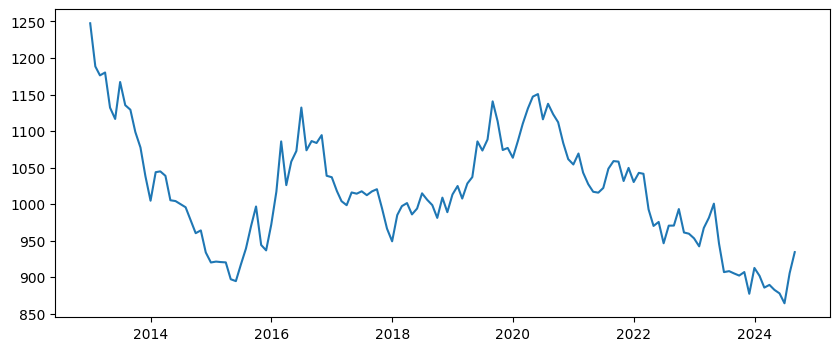

In [7]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(df_post_abe['KRW/JPY'])
plt.show()

In [8]:
df_real_xr = pd.read_excel(Path('data/world_real_xr.xls'), sheet_name='Data', skiprows=3)
df_real_xr = df_real_xr.set_index('Country Code')

In [9]:
df_real_xr_kor = df_real_xr.loc['KOR'].to_frame()
df_real_xr_kor = df_real_xr_kor.iloc[3:]
df_real_xr_kor = df_real_xr_kor.dropna()
df_real_xr_kor['KOR'] = df_real_xr_kor['KOR'].astype(float)
df_real_xr_kor['date'] = pd.to_datetime(df_real_xr_kor.index) + YearEnd()
df_real_xr_kor = df_real_xr_kor.set_index('date')
df_real_xr_kor.columns = ['KOR Real XR']
df_real_xr_kor.head(3)

,KOR Real XR
date,
1990-12-31,0.791111
1991-12-31,0.806041
1992-12-31,0.797916


In [10]:
df_real_xr_jpn = df_real_xr.loc['JPN'].to_frame()
df_real_xr_jpn = df_real_xr_jpn.iloc[3:]
df_real_xr_jpn = df_real_xr_jpn.dropna()
df_real_xr_jpn['JPN'] = df_real_xr_jpn['JPN'].astype(float)
df_real_xr_jpn['date'] = pd.to_datetime(df_real_xr_jpn.index) + YearEnd()
df_real_xr_jpn = df_real_xr_jpn.set_index('date')
df_real_xr_jpn.columns = ['JPN Real XR']
df_real_xr_jpn.head(3)

,JPN Real XR
date,
1990-12-31,1.295738
1991-12-31,1.386324
1992-12-31,1.465824


In [11]:
# 기존의 KOR와 JPN 데이터프레임을 합칩니다
df_combined = pd.concat([df_real_xr_kor, df_real_xr_jpn], axis = 1)

# KRW/100JPY 실질환율 계산
# KRW/USD를 JPY/USD로 나눈다.
df_combined['KRW/100JPY Real XR'] = df_combined['KOR Real XR'] / (df_combined['JPN Real XR'])

# 결과 확인
df_combined.tail(3)

,KOR Real XR,JPN Real XR,KRW/100JPY Real XR
date,,,
2021-12-31,0.723172,0.899195,0.804244
2022-12-31,0.627537,0.721953,0.869221
2023-12-31,0.612982,0.673903,0.909600


In [12]:
df_real_xr = df_combined['KRW/100JPY Real XR']

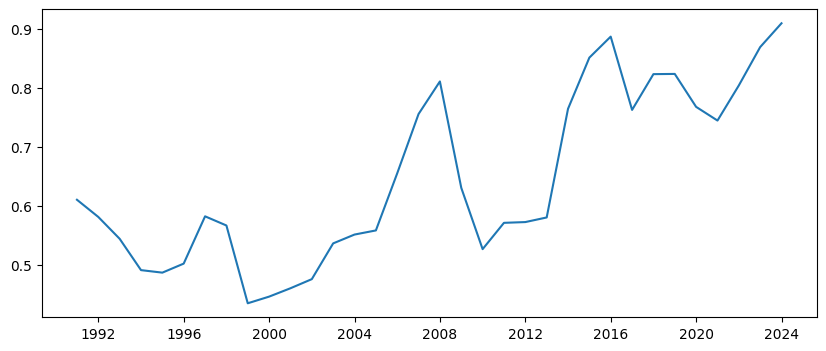

In [13]:
plt.plot(df_real_xr)
plt.show()

## Overlapping monthly forecasts

In [14]:
df_monthly = df_monthly.drop('ret', axis = 1)
df_merged = df_monthly.join(df_real_xr)
# ffill - forward fill
# bfill - backward fill
df_merged['KRW/100JPY Real XR'] = df_merged['KRW/100JPY Real XR'].fillna(method='ffill')

df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods=12) * 100

df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

df_merged.head(15)


,KRW/JPY,KRW/100JPY Real XR,ann_ret,F12.ann_ret
date,,,,
1977-05-31,174.67,NaN,NaN,23.346883
1977-06-30,180.11,NaN,NaN,30.525790
1977-07-31,181.95,NaN,NaN,38.186315
1977-08-31,181.12,NaN,NaN,40.569788
1977-09-30,181.51,NaN,NaN,40.890309
1977-10-31,193.58,NaN,NaN,39.787168
1977-11-30,200.15,NaN,NaN,22.348239
1977-12-31,201.65,NaN,NaN,24.329283
1978-01-31,200.05,NaN,NaN,20.774806


### Use OLS to fit the forecast model

In [15]:
df = df_merged[['KRW/100JPY Real XR', 'F12.ann_ret']]
df = df.dropna()

In [16]:
X = df['KRW/100JPY Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

In [17]:
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     6.386
Date:                Sat, 10 Aug 2024   Prob (F-statistic):             0.0119
Time:                        15:59:18   Log-Likelihood:                -1640.3
No. Observations:                 393   AIC:                             3285.
Df Residuals:                     391   BIC:                             3293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.7069      3.770     -1.779      0.076     -14.119       0.705
KRW/100JPY Real XR    14.6517      5.798      2.527      0.012       3.253      26.050
==============================================================================
Omnibus:                      177.090   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              844.783
Skew:                           1.935   Prob(JB):                    3.61e-184
Kurtosis:                       9.051   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Real XR 대신 PPP XR 활용하기

In [18]:
def load_world_bank_data(filepath, country, column):
    df = pd.read_excel(filepath, sheet_name='Data', skiprows = 3)

    df = df.set_index('Country Code')
    df = df.loc[country].to_frame()
    df = df.iloc[3:]
    df = df.dropna()
    df = df.astype(float)
    
    df['date'] = pd.to_datetime(df.index) + YearEnd()
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [19]:
df_ppp_xr_kor = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'KOR', 'PPP XR')
df_ppp_xr_jpn = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'JPN', 'PPP XR')

In [20]:
df_ppp_combined = pd.concat([df_ppp_xr_kor, df_ppp_xr_jpn], axis = 1)
df_ppp_combined.columns = ['KOR PPP XR', 'JPN PPP XR']
df_ppp_combined['KRW/100JPY PPP XR'] = df_ppp_combined['KOR PPP XR'] / (df_ppp_combined['JPN PPP XR'])
df_ppp_xr = df_ppp_combined.drop(['KOR PPP XR', 'JPN PPP XR'], axis = 1)

In [21]:
df_ppp_xr.head(3)

,KRW/100JPY PPP XR
date,
1990-12-31,2.984441
1991-12-31,3.165311
1992-12-31,3.355232


### Merge with monthly observations

In [22]:
df_merged = df_monthly.join(df_real_xr)
df_merged = df_merged.join(df_ppp_xr)
df_merged.head(3)

,KRW/JPY,KRW/100JPY Real XR,KRW/100JPY PPP XR
date,,,
1977-05-31,174.67,NaN,NaN
1977-06-30,180.11,NaN,NaN
1977-07-31,181.95,NaN,NaN


### Compute Real XR

In [23]:
df_merged['KRW/100JPY PPP XR'] = df_merged['KRW/100JPY PPP XR'].ffill()
df_merged.head(3)

,KRW/JPY,KRW/100JPY Real XR,KRW/100JPY PPP XR
date,,,
1977-05-31,174.67,NaN,NaN
1977-06-30,180.11,NaN,NaN
1977-07-31,181.95,NaN,NaN


In [24]:
df_merged['New Real XR'] = df_merged['KRW/100JPY PPP XR'] / df_merged['KRW/JPY'] * 100
df_merged.tail(3)

,KRW/JPY,KRW/100JPY Real XR,KRW/100JPY PPP XR,New Real XR
date,,,,
2024-06-30,864.31,NaN,8.453422,0.978054
2024-07-31,905.44,NaN,8.453422,0.933626
2024-08-31,934.32,NaN,8.453422,0.904767


In [25]:
df_merged['KRW/100JPY Real XR'] = df_merged['KRW/100JPY Real XR'].ffill()

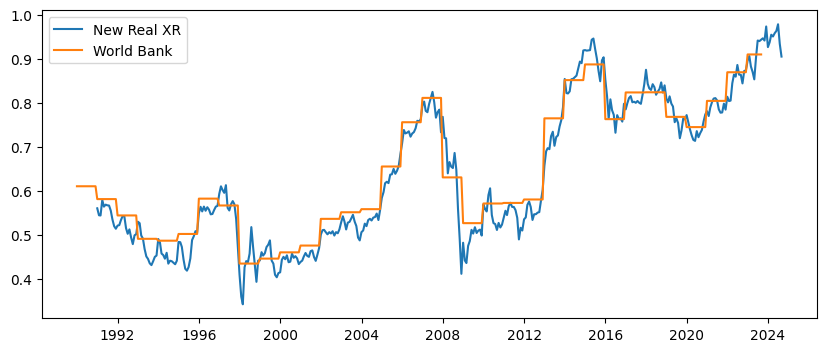

In [26]:
plt.plot(df_merged['New Real XR'], label='New Real XR')
plt.plot(df_merged['KRW/100JPY Real XR'].shift(-12), label='World Bank')
plt.legend()
plt.show()

## Compute annual XR return

In [27]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged.head(5)

,KRW/JPY,KRW/100JPY Real XR,KRW/100JPY PPP XR,New Real XR,ann_ret,F12.ann_ret
date,,,,,,
1977-05-31,174.67,NaN,NaN,NaN,NaN,23.346883
1977-06-30,180.11,NaN,NaN,NaN,NaN,30.525790
1977-07-31,181.95,NaN,NaN,NaN,NaN,38.186315
1977-08-31,181.12,NaN,NaN,NaN,NaN,40.569788
1977-09-30,181.51,NaN,NaN,NaN,NaN,40.890309


### Use OLS to fit the forecast model

In [28]:
df = df_merged[['New Real XR', 'F12.ann_ret']]
df = df.dropna()

In [29]:
X = df['New Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

In [30]:
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.088
Date:                Sat, 10 Aug 2024   Prob (F-statistic):              0.297
Time:                        15:59:18   Log-Likelihood:                -1642.9
No. Observations:                 393   AIC:                             3290.
Df Residuals:                     391   BIC:                             3298.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7687      3.333     -0.231      0.818      -7.321       5.784
New Real XR     5.3683      5.146      1.043      0.297      -4.749      15.485
==============================================================================
Omnibus:                      181.401   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              889.800
Skew:                           1.980   Prob(JB):                    6.06e-194
Kurtosis:                       9.218   Cond. No.                         9.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predict XR

In [31]:
last_obs = df_merged.iloc[-1]
last_obs

KRW/JPY               934.320000
KRW/100JPY Real XR      0.909600
KRW/100JPY PPP XR       8.453422
New Real XR             0.904767
ann_ret                 3.231794
F12.ann_ret                  NaN
Name: 2024-08-31 00:00:00, dtype: float64

In [32]:
last_xr = last_obs['KRW/JPY']
last_real_xr = last_obs['New Real XR']

In [33]:
last_xr

np.float64(934.32)

In [34]:
last_real_xr

np.float64(0.9047673662483775)

### OLS 결과 그대로 사용하여 예측

In [35]:
#exogeneous variables
exog = [1, last_real_xr]
results.predict(exog = exog)

array([4.08843257])

### Confidence Interval

In [36]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        iv_l[0],
        iv_u[0],
    ))

Confidence interval at alpha = 0.05: -27.27 ~ 35.44
Confidence interval at alpha = 0.25: -14.28 ~ 22.46
Confidence interval at alpha = 0.50: -6.68 ~ 14.86


### 환율 예측하기

In [37]:
pred_ret = results.predict(exog = exog)
last_xr * (1 + pred_ret[0] / 100)

np.float64(972.5190431444418)

In [38]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        last_xr * (1 + iv_l[0] / 100),
        last_xr * (1 + iv_u[0] / 100),
    ))

Confidence interval at alpha = 0.05: 679.57 ~ 1265.47
Confidence interval at alpha = 0.25: 800.86 ~ 1144.18
Confidence interval at alpha = 0.50: 871.92 ~ 1073.12


## 추가 지표 획득

In [39]:
def fetch_bok_data(service_code, stat_code=None, item=None):
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"
    
    if item is not None:
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
        
        if type(item['ITEM_CODE2']) is str:
            url += f"/{item['ITEM_CODE2']}"
        
    elif stat_code is not None:
        url += f"/{stat_code}"
    
    print(url)
    
    resp = requests.get(url, verify = False)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)
    
    return df

In [40]:
TARGET_STAT_CODES = [
    '731Y001',  # 3.1.1.1. 주요국 통화의 대원화환율
    '902Y008',  # 9.1.2.2. 국제 주요국 소비자물가지수
    '902Y009',  # 9.1.3.1. 국제 주요국 경상수지
    '902Y015',  # 9.1.4.1. 국제 주요국 경제성장률
    '902Y016',  # 9.1.4.2. 국제 주요국 국내총생산(GDP)
    '902Y023',  # 9.1.6.1. 주요국제금리
    '817Y002',  # 1.3.2.1. 시장금리(일별)
    '732Y001',  # 3.5. 외환보유액
]

In [41]:
dfs = []

for stat_code in TARGET_STAT_CODES:
    df = fetch_bok_data('StatisticItemList', stat_code = stat_code)
    
    dfs.append(df)

https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y016
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y023
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/817Y002
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/732Y001


In [42]:
df_item_codes = pd.concat(dfs, axis = 0)

In [43]:
df_item_codes.to_excel(Path('data/bok_item_codes.xlsx'), index = False)

In [44]:
df_item_codes = df_item_codes.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

### Download data values

In [45]:
data_download_list = pd.read_excel(Path('data/bok_data_download_list_jpy.xlsx'))

In [46]:
data_download_list

,name,STAT_CODE,STAT_NAME,ITEM_CODE,ITEM_CODE2,ITEM_NAME,CYCLE,UNIT_NAME
0,krw_100jpy_xr,731Y001,3.1.1.1. 주요국 통화의 대원화환율,0000002,NaN,원/일본엔(100엔),D,원
1,cpi_korea,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,KR,NaN,한국,M,2010=100
2,cpi_jp,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,JP,NaN,일본,M,2010=100
3,cpi_us,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,US,NaN,미국,M,2010=100
4,current_account_korea,902Y009,9.1.3.1. 국제 주요국 경상수지,KR,NaN,한국,Q,백만달러
5,current_account_jp,902Y009,9.1.3.1. 국제 주요국 경상수지,JP,NaN,일본,Q,백만달러
6,current_account_us,902Y009,9.1.3.1. 국제 주요국 경상수지,US,NaN,미국,Q,백만달러
7,gdp_growth_korea,902Y015,9.1.4.1. 국제 주요국 경제성장률,KOR,NaN,한국,Q,%
8,gdp_growth_jp,902Y015,9.1.4.1. 국제 주요국 경제성장률,JPN,NaN,일본,Q,%
9,gdp_growth_us,902Y015,9.1.4.1. 국제 주요국 경제성장률,USA,NaN,미국,Q,%


In [47]:
#iterate over row
for idx, row in data_download_list.iterrows():
    name = row['name']
    print(f"Downloading {name}...")
    
    idx = (row.STAT_CODE, row.ITEM_CODE, row.CYCLE)
    item = df_item_codes.loc[idx]
    item ={**item, **row}
    
    df = fetch_bok_data('StatisticSearch', item=item)
    df = df[['TIME', 'DATA_VALUE']]
    
    if row['CYCLE'] == 'D':
        df['date'] = pd.to_datetime(df['TIME'])
    
    elif row['CYCLE'] == 'M':
        df['date'] = pd.to_datetime(df['TIME'], format='%Y%m') + MonthEnd()
    
    elif row['CYCLE'] == 'Q':
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
    
    elif row['CYCLE'] == 'A':
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
    
    else:
        raise RuntimeError()
        
    df = df[['date','DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name, })
    
    df[name] = df[name].astype(float)
    
    df.to_excel(Path(f"data/{name}.xlsx"), index=False)
    
print('** Completed!! **')

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001/D/19770401/20240809/0000002
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195108/202406/KR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195501/202406/JP
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195501/202406/US
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1976Q1/2024Q1/KR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1996Q1/2024Q1/JP
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1973Q1/2024Q1/US
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015/Q/1960Q2/2024Q2/KOR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015/Q/1960Q2/2024Q1/JPN
https://ecos.bok.

## BOK 파일 불러오기

In [48]:
filenames = [
    'krw_jpy_xr',
    'current_account_korea',
    'current_account_us',
    'current_account_jp',
    'gdp_korea',
    'gdp_us',
    'gdp_jp',
    'gdp_growth_korea',
    'gdp_growth_jp',
    'gdp_growth_us',
    'cpi_korea',
    'cpi_jp',
    'cpi_us',
    'int_rate_korea',
    'int_rate_jp',
    'int_rate_us',
    'foreign_reserves',
]

In [49]:
dfs = []

for fname in filenames:
    print(f"Loding {fname}....")
    
    df = pd.read_excel(Path(f"data/{fname}.xlsx"))
    df = df.set_index('date')
    
    if fname in ['gdp_growth_korea',
        'gdp_growth_jp',
        'gdp_growth_us',
        'current_account_us',
        'current_account_jp',
        'current_account_korea',
                ]:
        df[fname] = df[fname].rolling(4).sum()
    
    dfs.append(df)
    
print('** Completed **')

Loding krw_jpy_xr....
Loding current_account_korea....
Loding current_account_us....
Loding current_account_jp....
Loding gdp_korea....
Loding gdp_us....
Loding gdp_jp....
Loding gdp_growth_korea....
Loding gdp_growth_jp....
Loding gdp_growth_us....
Loding cpi_korea....
Loding cpi_jp....
Loding cpi_us....
Loding int_rate_korea....
Loding int_rate_jp....
Loding int_rate_us....
Loding foreign_reserves....
** Completed **


### World Bank 데이터로 계산했었던 KOR/100JPY PPP XR 불러오기

In [50]:
dfs.append(df_ppp_xr)

## Merge the datasets

In [51]:
df_merged = pd.concat(dfs, axis = 1)
df_merged = df_merged.resample('ME').last()
df_merged = df_merged.ffill()
df_merged.loc['2010-01-01':].head()

,KRW/JPY,current_account_korea,current_account_us,current_account_jp,gdp_korea,gdp_us,gdp_jp,gdp_growth_korea,gdp_growth_jp,gdp_growth_us,cpi_korea,cpi_jp,cpi_us,int_rate_korea,int_rate_jp,int_rate_us,foreign_reserves,KRW/100JPY PPP XR
date,,,,,,,,,,,,,,,,,,
2010-01-31,1287.00,33087.6,-379736.0,145677.71,943708.5,14478067.0,5289493.7,5.399,-1.661,0.118,98.82,100.09,99.37,2.88,0.20,0.45,273693584.0,7.189963
2010-02-28,1299.31,33087.6,-379736.0,145677.71,943708.5,14478067.0,5289493.7,5.399,-1.661,0.118,99.02,100.09,99.40,2.88,0.19,0.44,270659721.0,7.189963
2010-03-31,1217.68,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.22,100.30,99.81,2.83,0.23,0.43,272331061.0,7.189963
2010-04-30,1186.77,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.62,100.30,99.98,2.51,0.30,0.40,278873477.0,7.189963
2010-05-31,1318.54,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.72,100.30,100.06,2.45,0.45,0.39,270221038.0,7.189963


# >>반영할 수 있는 지표들

### 환율 수익률

In [52]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

### Real XR

In [53]:
df_merged['real_xr'] = df_merged['KRW/100JPY PPP XR'] / df_merged['KRW/JPY']

### Current accounts(경상수지) relative to GDP

In [54]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100
df_merged['ca_gdp_jp'] = df_merged['current_account_jp'] / df_merged['gdp_jp'] * 100

In [55]:
df_merged.loc['2012-12-26':][['ca_gdp_korea', 'ca_gdp_jp']].head(3)

,ca_gdp_korea,ca_gdp_jp
date,,
2012-12-31,3.817592,0.958443
2013-01-31,3.817592,0.958443
2013-02-28,3.817592,0.958443


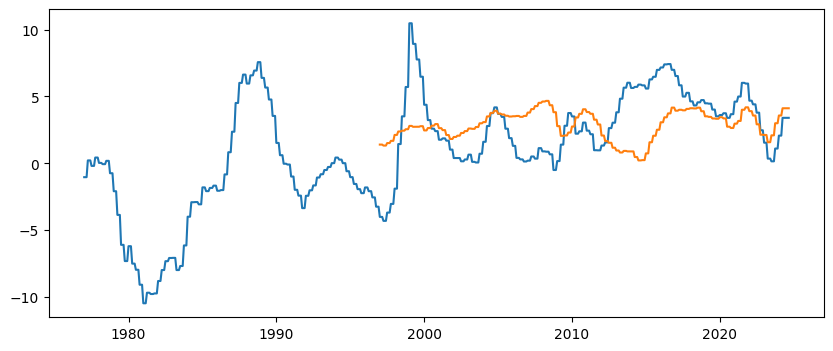

In [56]:
#stationary process

plt.plot(df_merged['ca_gdp_korea'])
plt.plot(df_merged['ca_gdp_jp'])
plt.show()

### GDP Growth

In [57]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods=12) * 100
df_merged['gdp_growth_jp2'] = df_merged['gdp_jp'].pct_change(periods=12) * 100

In [58]:
df_merged.loc[['2018-12-31', '2019-12-31']][['gdp_jp', 'gdp_growth_jp', 'gdp_growth_jp2']]

,gdp_jp,gdp_growth_jp,gdp_growth_jp2
date,,,
2018-12-31,5040880.9,-0.271,2.231741
2019-12-31,5117993.9,-2.006,1.529752


### Inflation (YoY, Y/Y)

In [59]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods=12) * 100
df_merged['infl_jp'] = df_merged['cpi_jp'].pct_change(periods=12) * 100

### 상대적 인플레이션 & 금리 차이

In [60]:
df_merged['infl_diff'] = df_merged['infl_korea'] - df_merged['infl_jp']
df_merged['int_rate_diff'] = df_merged['int_rate_korea'] - df_merged['int_rate_jp']

### GDP 대비 외환보유액 및 증가율

In [61]:
df_merged['reserves_to_gdp'] = df_merged['foreign_reserves'] / df_merged['gdp_korea'] /1000 * 100
df_merged['reserves_growth'] = df_merged['foreign_reserves'].pct_change(periods=12) * 100

### 필요한 컬럼만 남김

In [62]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr',
    'ca_gdp_korea', 'ca_gdp_jp',
    'gdp_growth_korea', 'gdp_growth_jp',
    'infl_diff', 'int_rate_diff',
    'reserves_to_gdp', 'reserves_growth'
]]

In [63]:
df_sample = df_sample.dropna()
df_sample = df_sample.loc['1998-12-31':]

In [64]:
df_sample.head(3)

,F12.ann_ret,real_xr,ca_gdp_korea,ca_gdp_jp,gdp_growth_korea,gdp_growth_jp,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth
date,,,,,,,,,,
1998-12-31,6.489981,0.004422,10.477291,2.798314,-3.383,-0.676,3.367014,2.56,13.592840,155.033859
1999-01-31,3.873215,0.004610,10.477291,2.798314,-3.383,-0.676,1.269399,2.11,13.999523,127.925687
1999-02-28,0.651967,0.004533,10.477291,2.798314,-3.383,-0.676,0.265566,1.80,14.485070,107.584787


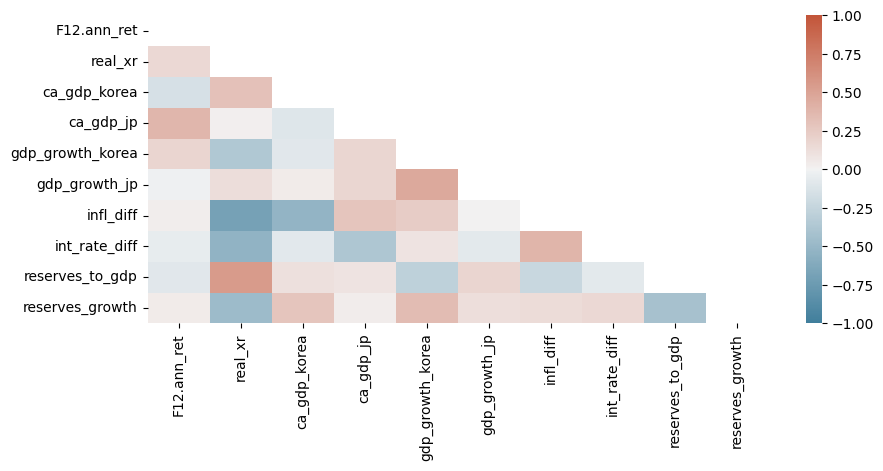

In [65]:
corr = df_sample.corr()
# triu = upper triangle
mask = np.triu(np.ones_like(corr))
cmap=sns.diverging_palette(230, 20, as_cmap=True)
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1)
plt.show()

In [66]:
df_sample

,F12.ann_ret,real_xr,ca_gdp_korea,ca_gdp_jp,gdp_growth_korea,gdp_growth_jp,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth
date,,,,,,,,,,
1998-12-31,6.489981,0.004422,10.477291,2.798314,-3.383,-0.676,3.367014,2.56,13.592840,155.033859
1999-01-31,3.873215,0.004610,10.477291,2.798314,-3.383,-0.676,1.269399,2.11,13.999523,127.925687
1999-02-28,0.651967,0.004533,10.477291,2.798314,-3.383,-0.676,0.265566,1.80,14.485070,107.584787
1999-03-31,3.053360,0.004585,8.936132,2.731757,6.470,-0.827,0.912194,1.65,15.005900,93.118709
1999-04-30,4.126127,0.004726,8.936132,2.731757,6.470,-0.827,0.526887,1.28,15.479473,66.733513
...,...,...,...,...,...,...,...,...,...,...
2023-04-30,-11.787574,0.008531,0.352616,1.579321,1.176,2.433,0.145276,-1.53,25.490139,-5.033205
2023-05-31,-7.203112,0.009024,0.352616,1.579321,1.176,2.433,0.133449,-1.51,25.149604,-5.969863
2023-06-30,-4.703573,0.009412,0.149446,2.093027,0.929,2.204,-0.604380,-1.47,25.177715,-3.838753


In [67]:
X = df_sample
X = sm.add_constant(X)
Y = df_sample['F12.ann_ret']

In [68]:
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.107e+31
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:59:27   Log-Likelihood:                 9193.4
No. Observations:                 297   AIC:                        -1.836e+04
Df Residuals:                     286   BIC:                        -1.832e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.309e-14   7.15e-15     -3.232      0.001   -3.72e-14   -9.03e-15
F12.ann_ret          1.0000   5.11e-17   1.96e+16      0.000       1.000       1.000
real_xr           2.046e-12   9.02e-13      2.269      0.024    2.71e-13    3.82e-12
ca_gdp_korea     -8.327e-17   3.25e-16     -0.257      0.798   -7.22e-16    5.56e-16
ca_gdp_jp         1.553e-15   7.72e-16      2.011      0.045    3.29e-17    3.07e-15
gdp_growth_korea  6.106e-16   2.57e-16      2.377      0.018    1.05e-16    1.12e-15
gdp_growth_jp    -3.886e-16   2.86e-16     -1.357      0.176   -9.52e-16    1.75e-16
infl_diff         8.882e-16   5.49e-16      1.617      0.107   -1.93e-16    1.97e-15
int_rate_diff     8.604e-16   6.56e-16      1.312      0.190    -4.3e-16    2.15e-15
reserves_to_gdp   1.527e-16   2.24e-16      0.680      0.497   -2.89e-16    5.94e-16
reserves_growth   2.047e-16   4.12e-17      4.972      0.000    1.24e-16    2.86e-16
==============================================================================
Omnibus:                      183.834   Durbin-Watson:                   0.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2009.542
Skew:                           2.349   Prob(JB):                         0.00
Kurtosis:                      14.845   Cond. No.                     5.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""